In [ ]:
#loading model and running reservoir data through the model
#Jessica Besnier

In [36]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.tree import DecisionTreeRegressor
import joblib



# Load the trained pipeline
loaded_pipeline = joblib.load('Z:/Research_Projects/Reservoir_Project/ML_outputs/models/monthly_Run_test_RandomForestRegressor_35_model.joblib')
model= joblib.load('Z:/Research_Projects/Reservoir_Project/ML_outputs/models/Run_test_RandomForestRegressor_35_model.joblib')

# Prepare new data
res_name = 'agua_vermelha'
input_data_path = 'Z:/Research_Projects/Reservoir_Project/data/regression_variables/varaibles_ts_clean_top_anom/' + res_name + '_var_normalized.csv'

# Load input data
input_data = pd.read_csv(input_data_path)
input_data = input_data.dropna()

def create_regression_dataset():
    df = input_data[['normalized_reservoir_height', 'tws', 'precipitation', 'temp', 'volume', 'area', 'discharge', 'Res_time', 'depth', 'wshd_area','elevation' ]] #timeseries and static varaibles for algortihm to tell the difference between reservoirs 
    
    X = df[['tws', 'precipitation', 'temp', 'volume', 'area', 'discharge', 'Res_time', 'depth', 'wshd_area','elevation']]
    y = df['normalized_reservoir_height']
    return df, X, y

def create_datasets():
    """Create example datasets"""

    df_regression, _, __ = create_regression_dataset()
    return df_regression, 

df_regression = create_datasets()


In [37]:

def time_series_to_tabular(included_columns):
    df, _, __ = create_regression_dataset()

    TARGET = 'normalized_reservoir_height' # The column in df we want to forecast
    LAG = 36 # This is how far back we want to look for features
    HORIZON = 6 # This is how far forward we want forecast

    # Fill in missing values
    cols = df.columns
    index = df.index
    df = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(df)
    df = pd.DataFrame(df, columns=cols, index=index) # convert back to dataframe

    df = df[included_columns]    


    def create_lag_features(df, target, lag):
        
        for col in df.columns:
            for i in range(1, lag+1):
                df[f'{col}-{i}'] = df[col].shift(i)

            # Drop non-target values (we only keep historical feature values)
            if col != target:
                df = df.drop(col, axis=1)
        # OPTIONAL: Drop first N rows where N = lag
        # Alternatively, we could impute the missing data
        df = df.iloc[lag:]
        return df 

    def create_future_values(df, target, horizon):
        targets = [ target ]
        for i in range(1, horizon):
            col_name = f'{target}+{i}'
            df[col_name] = df[target].shift(-i)
            targets.append(col_name)

        # Optional: Drop rows missing future target values
        df = df[df[targets[-1]].notna()]
        return df, targets


    print('\nInitial df shape:', df.shape)
    # Create feature data (X)
    df = create_lag_features(df, TARGET, LAG)
    print('\ndf lag shape after feature creation:', df.shape)

    # Create targets to forecast (y)
    df, targets = create_future_values(df, TARGET, HORIZON)
    print('\ndf horizon shape after feature creation:', df.shape)

    # Separate features (X) and targets (y)
    y = df[targets]
    X = df.drop(targets, axis=1)
    #df.set_index('time', inplace=True)

    print('\nShape of X (features):', X.shape)
    print('Shape of y (target(s)):', y.shape)

    return X, y

In [38]:
if __name__ == '__main__':

    time_series_to_tabular(included_columns= ['normalized_reservoir_height', 'tws', 'precipitation', 'temp',])


Initial df shape: (167, 4)

df lag shape after feature creation: (131, 145)

df horizon shape after feature creation: (126, 150)

Shape of X (features): (126, 144)
Shape of y (target(s)): (126, 6)


In [58]:


X, y = time_series_to_tabular(included_columns= ['normalized_reservoir_height', 'tws', 'precipitation', 'temp',])
loaded_pipeline.fit(X, y)

# #through pipeline

scaler = loaded_pipeline.named_steps['scaler']
X_new = scaler.transform(X)
predictions_new = model.predict(X_new)

predictions_df = pd.DataFrame(predictions_new, columns=[f'Predicted_{col}' for col in y.columns])
actual_df = y.reset_index(drop=True)  # Reset index for correct alignment
result_df = pd.concat([actual_df, predictions_df], axis=1)
result_df.to_csv(f'Z:/Research_Projects/Reservoir_Project/ML_outputs/tables_outputs_csv/predicted_vs_actual/reservoir_individual_test_predicted_vs_actual.csv', index=False)


#predictions_new = loaded_pipeline.predict(X)
#another option
# print(loaded_pipeline.named_steps)
# multioutput_regressor = loaded_pipeline.named_steps['multioutput']
# model_regressor = multioutput_regressor.estimators_[0]  
# X_new_transformed = X_new

# predictions_new = model_regressor.predict(X_new_transformed)



Initial df shape: (167, 4)

df lag shape after feature creation: (131, 145)

df horizon shape after feature creation: (126, 150)

Shape of X (features): (126, 144)
Shape of y (target(s)): (126, 6)


ValueError: X has 144 features, but Normalizer is expecting 35 features as input.

3.083400000636338e-05
1.711934997999997
0.6354593791825399


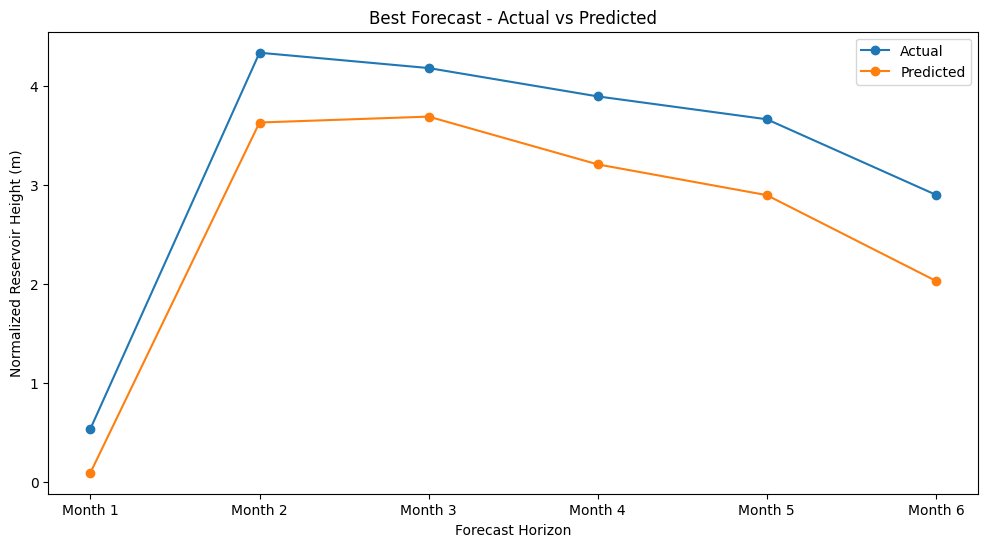

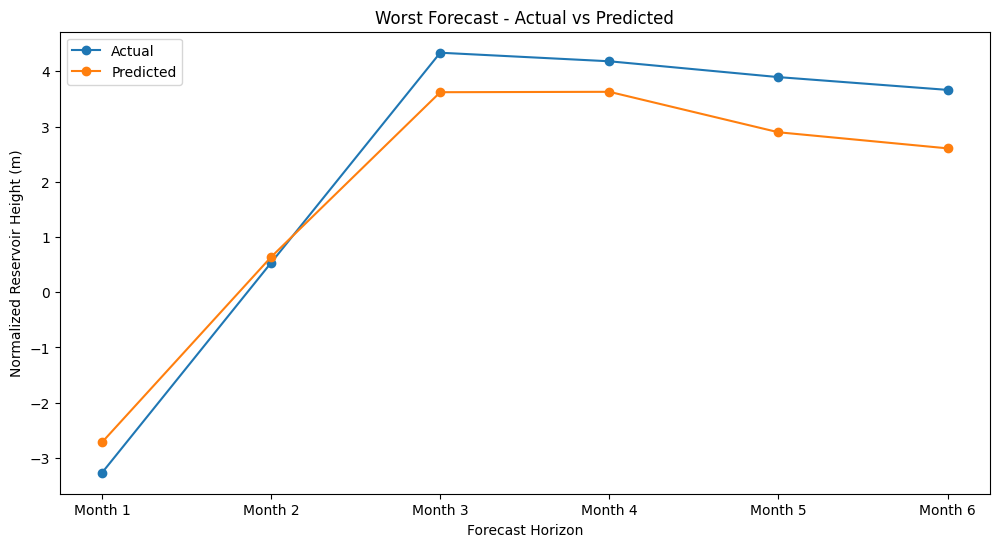

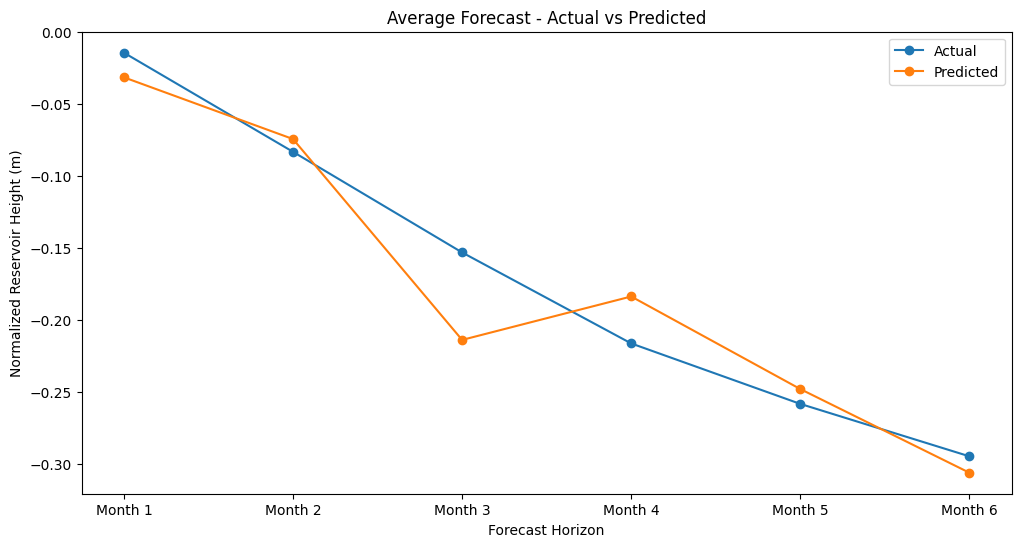

In [57]:
#plotting actual vs. predicted
import matplotlib 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score



# Plotting Best, Worst, and Average Days
predicted_actual_df = pd.read_csv('Z:/Research_Projects/Reservoir_Project/ML_outputs/tables_outputs_csv/predicted_vs_actual/reservoir_individual_test_predicted_vs_actual.csv')
# Calculate metrics for each day

predicted_cols = [f'Predicted_normalized_reservoir_height+{i}' for i in range(1, 5+ 1)]
actual_cols = [f'normalized_reservoir_height+{i}' for i in range(1, 5 + 1)]

mean_mae_store = []

for index, row in predicted_actual_df.iterrows():
    for p, a in zip(predicted_cols, actual_cols):
        #print(row[p])
        #print(row[a])
        mae = mean_absolute_error([row[p]], [row[a]]) #needs to be a list
        #print(mae)
        mean_mae= np.mean(mae)
        mean_mae_store.append(mean_mae)

predicted_actual_df['MAE'] = pd.Series(mean_mae_store)

# Find best, worst, and average days
best_day = predicted_actual_df.loc[predicted_actual_df['MAE'].idxmin()]
worst_day = predicted_actual_df.loc[predicted_actual_df['MAE'].idxmax()]
average_day = predicted_actual_df.mean()

print(best_day['MAE'])
print(worst_day['MAE'])
print(average_day['MAE'])

best_day = best_day.drop('MAE')
worst_day =worst_day.drop('MAE')
average_day =average_day.drop('MAE')


# Plotting the best, worst, and average days
plt.figure(figsize=(12, 6))
plt.plot(best_day.index[len(predicted_actual_df.columns)//2:], best_day.values[:len(predicted_actual_df.columns)//2], label='Actual', marker='o')
plt.plot(best_day.index[len(predicted_actual_df.columns)//2:], best_day.values[len(predicted_actual_df.columns)//2:], label='Predicted', marker='o')
custom_labels = ['Month 1', 'Month 2', 'Month 3', 'Month 4', 'Month 5', 'Month 6']
plt.xticks(best_day.index[len(predicted_actual_df.columns)//2:], custom_labels)
plt.title('Best Forecast - Actual vs Predicted')
plt.xlabel('Forecast Horizon') #pass in a list of names 
#plt.xticks(["Day 1", "Day 2", "Day 3", "Day 4", "Day 5"])
plt.ylabel('Normalized Reservoir Height (m)')
plt.legend()
#plt.savefig('Z:\Research_Projects\Reservoir_Project\ML_outputs/best_forecast_rf35_csv')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(worst_day.index[len(predicted_actual_df.columns)//2:], worst_day.values[:len(predicted_actual_df.columns)//2], label='Actual', marker='o')
plt.plot(worst_day.index[len(predicted_actual_df.columns)//2:], worst_day.values[len(predicted_actual_df.columns)//2:], label='Predicted', marker='o')
plt.xticks(worst_day.index[len(predicted_actual_df.columns)//2:], custom_labels)
plt.title('Worst Forecast - Actual vs Predicted')
plt.xlabel('Forecast Horizon')
plt.ylabel('Normalized Reservoir Height (m)')
plt.legend()
#plt.savefig('Z:\Research_Projects\Reservoir_Project\ML_outputs/worst_forecast_rf35_csv')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(average_day.index[len(predicted_actual_df.columns)//2:], average_day.values[:len(predicted_actual_df.columns)//2], label='Actual', marker='o')
plt.plot(average_day.index[len(predicted_actual_df.columns)//2:], average_day.values[len(predicted_actual_df.columns)//2:], label='Predicted', marker='o')
plt.xticks(average_day.index[len(predicted_actual_df.columns)//2:], custom_labels)
plt.title('Average Forecast - Actual vs Predicted')
plt.xlabel('Forecast Horizon')
plt.ylabel('Normalized Reservoir Height (m)')
plt.legend()
#plt.savefig('Z:\Research_Projects\Reservoir_Project\ML_outputs/avg_forecast_rf35_csv')
plt.show()